In [1]:
from pydub import AudioSegment
import os
import subprocess
import shutil
import wave
import numpy as np
from scipy.io import wavfile
from pydub.silence import detect_nonsilent
import contextlib
import matplotlib.pyplot as plt
from IPython import display
import random
import librosa
import soundfile as sf

In [2]:
# Функция для конвертации ogg в wav
def convert_ogg_to_wav(input_file, output_file):
    try:
        # Загружаем ogg файл
        audio = AudioSegment.from_file(input_file, format="ogg")
        
        # Сохраняем как wav
        audio.export(output_file, format="wav")
    except Exception as e:
        print(f"convert_ogg_to_wav: Ошибка при конвертации: {e}")

In [3]:
def convert_mp3_to_wav(input_file, output_file):
    try:
        # Загружаем mp3 файл
        audio = AudioSegment.from_mp3(input_file)
        # Сохраняем как wav
        audio.export(output_file, format="wav")
    except Exception as e:
        print(f"convert_mp3_to_wav: Ошибка при конвертации: {e}")

In [4]:
def convert_opus_to_wav(input_file, output_file):
    try:
        if not os.path.exists(input_file):
            print(f"convert_opus_to_wav: Файл {input_file} не найден!")
            return
            
        command = [
            "ffmpeg",
            "-i", input_file,      
            "-acodec", "pcm_s16le",
            "-ar", "44100",
            "-ac", "2",
            output_file
        ]

        subprocess.run(command, check=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

    except subprocess.CalledProcessError as e:
        print(f"convert_opus_to_wav: Ошибка FFmpeg: {e}")
    except Exception as e:
        print(f"convert_opus_to_wav: Другая ошибка: {e}")


In [5]:
def move_file(source, destination):
    try:
        shutil.copy2(source, destination)
    except Exception as e:
        print(f"move_file: Ошибка при перемещении файла: {e}")

In [6]:
def convert_wav_to_16bit(input_file, output_file):
    try:
        # Загружаем WAV файл
        audio = AudioSegment.from_wav(input_file)
        
        # Преобразуем в 16-битный формат
        audio = audio.set_sample_width(2)  # 2 байта = 16 бит
        
        # Сохраняем как 16-битный WAV
        audio.export(output_file, format="wav")
    except Exception as e:
        print(f"convert_wav_to_16bit: Ошибка при конвертации файла {input_file}: {e}")

In [7]:
def convert_stereo_to_mono(input_path, output_path):
    try:
        with wave.open(input_path, "rb") as wav_file:
            params = wav_file.getparams()
            frames = wav_file.readframes(params.nframes)
    
        # Если аудио стерео, усредняем каналы
        if params.nchannels == 2:
            audio_data = np.frombuffer(frames, dtype=np.int16)
            audio_data = audio_data.reshape(-1, 2)
            mono_data = audio_data.mean(axis=1).astype(np.int16)
        else:
            mono_data = np.frombuffer(frames, dtype=np.int16)
    
        # Создаем выходную директорию, если она не существует
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
    
        wavfile.write(output_path, params.framerate, mono_data)
    except Exception as e:
        print(f"convert_stereo_to_mono: Ошибка при конвертации файла {input_path}: {e}")

In [8]:
def remove_silence(input_path, output_path, silence_thresh=-50, min_silence_len=100):
    """Удаляет тишину в начале и конце аудиофайла."""
    try:
        audio = AudioSegment.from_file(input_path)
        # Поиск неслышимых сегментов
        nonsilent_ranges = detect_nonsilent(audio, min_silence_len=min_silence_len, silence_thresh=silence_thresh)
    
        if nonsilent_ranges:
            # Определение начала и конца неслышимых сегментов
            start_trim = nonsilent_ranges[0][0]
            end_trim = nonsilent_ranges[-1][1]
    
            # Обрезка аудио
            trimmed_audio = audio[start_trim:end_trim]
            trimmed_audio.export(output_path, format="wav")
    except Exception as e:
        print(f"remove_silence: Ошибка обработки {input_path}: {e}")   

In [9]:
def convert_to_16000hz(input_path, output_path):  
    try:
        audio = AudioSegment.from_file(input_path)
        audio = audio.set_frame_rate(16000)  # Установка частоты дискретизации
        audio.export(output_path, format="wav")
    except Exception as e:
        print(f"convert_to_16000hz: Ошибка обработки {input_path}: {e}")

In [10]:
def transport_file(old_dir, new_dir):
    if new_dir and not os.path.exists(new_dir):
            os.makedirs(new_dir)
    for dirname, _, filenames in os.walk(old_dir):
        for filename in filenames:
            if "ogg" in filename:
                convert_ogg_to_wav(os.path.join(dirname,filename),
                                   os.path.join(new_dir,filename.replace(".ogg", ".wav")))
            elif "opus" in filename:
                convert_opus_to_wav(os.path.join(dirname,filename),
                                   os.path.join(new_dir,filename.replace(".opus", ".wav")))
            elif "mp3" in filename:
                convert_mp3_to_wav(os.path.join(dirname,filename),
                                   os.path.join(new_dir,filename.replace(".mp3", ".wav")))
            else:
                if "Catch" in filename:
                    new_dir = 'output/ML/Catch'
                if "Gun" in filename:
                    new_dir = 'output/ML/Gun'
                if "Index" in filename:
                    new_dir = 'output/ML/Index'
                if "Like" in filename:
                    new_dir = 'output/ML/Like'
                if "Relax" in filename:
                    new_dir = 'output/ML/Relax'
                if "Rock" in filename:
                    new_dir = 'output/ML/Rock'
                move_file(os.path.join(dirname,filename), os.path.join(new_dir,filename))
            convert_wav_to_16bit(os.path.join(new_dir,filename.replace(".ogg", ".wav")
                                              .replace(".opus", ".wav").replace(".mp3", ".wav")),
                                 os.path.join(new_dir,filename.replace(".ogg", ".wav")
                                              .replace(".opus", ".wav").replace(".mp3", ".wav")))
            convert_stereo_to_mono(os.path.join(new_dir,filename.replace(".ogg", ".wav")
                                              .replace(".opus", ".wav").replace(".mp3", ".wav")),
                                 os.path.join(new_dir,filename.replace(".ogg", ".wav")
                                              .replace(".opus", ".wav").replace(".mp3", ".wav")))
            remove_silence(os.path.join(new_dir,filename.replace(".ogg", ".wav")
                                              .replace(".opus", ".wav").replace(".mp3", ".wav")),
                                 os.path.join(new_dir,filename.replace(".ogg", ".wav")
                                              .replace(".opus", ".wav").replace(".mp3", ".wav")))
            convert_to_16000hz(os.path.join(new_dir,filename.replace(".ogg", ".wav")
                                              .replace(".opus", ".wav").replace(".mp3", ".wav")),
                                 os.path.join(new_dir,filename.replace(".ogg", ".wav")
                                              .replace(".opus", ".wav").replace(".mp3", ".wav")))

In [11]:
# convert_ogg_to_wav("/kaggle/input/test-audio/Test2.ogg","/kaggle/working/Test2.wav")
# convert_wav_to_16bit("/kaggle/working/Test2.wav","/kaggle/working/Test2.wav")
# convert_stereo_to_mono("/kaggle/working/Test2.wav","/kaggle/working/Test2.wav")
# remove_silence("/kaggle/working/Test2.wav","/kaggle/working/Test2.wav")
# convert_to_16000hz("/kaggle/working/Test2.wav","/kaggle/working/Test2.wav")

In [12]:
# def get_audio_duration(filepath):
#     """Возвращает длительность аудиофайла в секундах."""
#     try:
#         audio = AudioSegment.from_file(filepath)  # pydub автоматически определяет формат
#         return len(audio) / 1000  # Длительность в секундах
#     except Exception as e:
#         print(f"Не удалось прочитать файл {filepath}: {e}")
#         return None

# # Корневая директория
# root_dir = "/kaggle/input/audio-ml/ML"  # Укажите свою директорию

# audio_durations = []

# # Рекурсивный обход папок
# for root, dirs, files in os.walk(root_dir):
#     for file in files:
#         if file.lower().endswith((".wav", ".opus", ".ogg", ".mp3", ".flac")):  # Добавляем больше форматов
#             file_path = os.path.join(root, file)
#             duration = get_audio_duration(file_path)
#             if duration is not None:
#                 audio_durations.append(duration)

# # Визуализация
# plt.figure(figsize=(10, 6))
# plt.hist(audio_durations, bins=30, color='skyblue', edgecolor='black')
# plt.xlabel("Длительность аудиофайла (секунды)")
# plt.ylabel("Количество файлов")
# plt.title("Распределение длительности аудиофайлов")
# plt.show()


In [13]:
transport_file("input/ML/Relax", "output/ML/Relax")
transport_file("input/ML/Catch", "output/ML/Catch")
transport_file("input/ML/Gun", "output/ML/Gun")
transport_file("input/ML/Index", "output/ML/Index")
transport_file("input/ML/Like", "output/ML/Like")
transport_file("input/ML/Rock", "output/ML/Rock")

In [14]:
transport_file("input/ML/Watsapp/Catch", "output/ML/Catch")
transport_file("input/ML/Watsapp/Gun", "output/ML/Gun")
transport_file("input/ML/Watsapp/Relax", "output/ML/Relax")
transport_file("input/ML/Watsapp/Index", "output/ML/Index")
transport_file("input/ML/Watsapp/Like", "output/ML/Like")
transport_file("input/ML/Watsapp/Rock", "output/ML/Rock")

In [15]:
transport_file("input/ML/Запись Дин", "")

In [16]:
transport_file("input/noises", "output/noises")

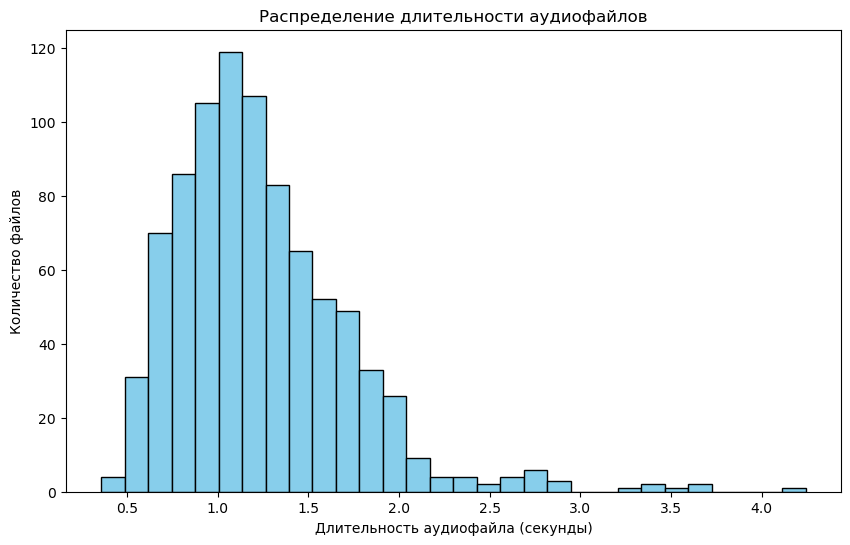

In [17]:
def get_audio_duration(filepath):
    """Возвращает длительность аудиофайла в секундах."""
    try:
        audio = AudioSegment.from_file(filepath)  # pydub автоматически определяет формат
        return len(audio) / 1000  # Длительность в секундах
    except Exception as e:
        print(f"Не удалось прочитать файл {filepath}: {e}")
        return None

# Корневая директория
root_dir = "output/ML"  # Укажите свою директорию

audio_durations = []

# Рекурсивный обход папок
for root, dirs, files in os.walk(root_dir):
    for file in files:
        if file.lower().endswith((".wav", ".opus", ".ogg", ".mp3", ".flac")):  # Добавляем больше форматов
            file_path = os.path.join(root, file)
            duration = get_audio_duration(file_path)
            if duration is not None:
                audio_durations.append(duration)

# Визуализация
plt.figure(figsize=(10, 6))
plt.hist(audio_durations, bins=30, color='skyblue', edgecolor='black')
plt.xlabel("Длительность аудиофайла (секунды)")
plt.ylabel("Количество файлов")
plt.title("Распределение длительности аудиофайлов")
plt.show()


In [18]:
def delete_blowout_files(root_dir, length):
    deleted_count = 0

    for subdir, _, files in os.walk(root_dir):
        for file in files:
            file_path = os.path.join(subdir, file)
            if file.lower().endswith(('.wav')):
                try:
                    audio = AudioSegment.from_file(file_path)
                    duration = len(audio) / 1000  # Длительность в секундах

                    if duration > length:
                        display.display(display.Audio(file_path, rate=16000))
                        os.remove(file_path)
                        deleted_count += 1
                        print(f"Удален файл: {file_path} (длительность: {duration:.2f} секунд)")
                except Exception as e:
                    print(f"Ошибка обработки {file_path}: {e}")

    print(f"\nВсего удалено файлов: {deleted_count}")

# Пример использования
root_dir = "output/ML"  # Укажите путь к вашей директории
delete_blowout_files(root_dir, 2.6)


Удален файл: output/ML/Catch/audio_2025-01-10_11-30-11.wav (длительность: 2.84 секунд)


Удален файл: output/ML/Catch/audio_2025-01-11_20-52-06.wav (длительность: 4.24 секунд)


Удален файл: output/ML/Gun/audio_2025-01-11_20-52-38.wav (длительность: 3.67 секунд)


Удален файл: output/ML/Gun/audio_2025-02-12_13-58-27.wav (длительность: 2.75 секунд)


Удален файл: output/ML/Index/audio_2025-01-09_13-52-05.wav (длительность: 2.63 секунд)


Удален файл: output/ML/Index/audio_2025-01-10_11-30-55.wav (длительность: 3.38 секунд)


Удален файл: output/ML/Index/audio_2025-01-11_20-52-16.wav (длительность: 3.58 секунд)


Удален файл: output/ML/Like/audio_2025-01-10_11-31-07.wav (длительность: 2.87 секунд)


Удален файл: output/ML/Like/audio_2025-01-11_20-52-49.wav (длительность: 3.38 секунд)


Удален файл: output/ML/Like/audio_2025-02-19_18-40-25.wav (длительность: 2.68 секунд)


Удален файл: output/ML/Like/Like 2.wav (длительность: 2.79 секунд)


Удален файл: output/ML/Relax/audio_2025-01-10_11-29-51.wav (длительность: 2.74 секунд)


Удален файл: output/ML/Relax/audio_2025-01-11_19-45-48.wav (длительность: 2.69 секунд)


Удален файл: output/ML/Relax/audio_2025-01-11_20-51-54.wav (длительность: 3.63 секунд)


Удален файл: output/ML/Rock/audio_2025-01-10_11-30-44.wav (длительность: 3.33 секунд)


Удален файл: output/ML/Rock/audio_2025-01-11_19-46-08.wav (длительность: 2.70 секунд)


Удален файл: output/ML/Rock/audio_2025-01-11_20-52-26.wav (длительность: 2.71 секунд)


Удален файл: output/ML/Rock/audio_2025-01-11_20-53-20.wav (длительность: 2.94 секунд)

Всего удалено файлов: 18


при min_silence_len=10 удаляется 52 файла

при min_silence_len=500 удаляется 23 файла

при min_silence_len=100 удаляется 18 файла

In [19]:
def get_sample_rate(file_path):
    try:
        sample_rate, _ = wavfile.read(file_path)
        return sample_rate
    except Exception as e:
        print(f"Не удалось прочитать файл {file_path}: {e}")
        return None

# Путь к вашей корневой директории с аудиофайлами
root_dir = "output/ML"

sample_rates = []

for root, _, files in os.walk(root_dir):
    for file in files:
        if file.lower().endswith(".wav"):
            file_path = os.path.join(root, file)
            sample_rate = get_sample_rate(file_path)
            if sample_rate:
                sample_rates.append(sample_rate)

if sample_rates:
    sample_rates = np.array(sample_rates)
    print(f"Минимальная частота дискретизации: {sample_rates.min()} Гц")
    print(f"Максимальная частота дискретизации: {sample_rates.max()} Гц")
    print(f"Средняя частота дискретизации: {sample_rates.mean():.2f} Гц")
    print(f"Медиана частоты дискретизации: {np.median(sample_rates)} Гц")
    print(f"Стандартное отклонение частоты дискретизации: {sample_rates.std():.2f} Гц")
else:
    print("Не найдено ни одного аудиофайла с определенной частотой дискретизации.")

Минимальная частота дискретизации: 16000 Гц
Максимальная частота дискретизации: 16000 Гц
Средняя частота дискретизации: 16000.00 Гц
Медиана частоты дискретизации: 16000.0 Гц
Стандартное отклонение частоты дискретизации: 0.00 Гц


In [20]:

# Параметры: пути к входной и выходной папкам
input_folder = "output/noises"      # Папка, где находятся исходные файлы шума
output_folder = "output/noises_fragments"   # Папка для сохранения фрагментов

# Создаём выходную папку, если её нет
os.makedirs(output_folder, exist_ok=True)

# Определяем длительность фрагмента в миллисекундах (3 секунды = 3000 мс)
segment_length = 2600

# Проходим по всем файлам в входной папке
for file_name in os.listdir(input_folder):
    # Проверяем, что файл имеет аудио формат (например, .wav или .mp3)
    if file_name.lower().endswith(('.wav', '.mp3')):
        # Полный путь к файлу
        file_path = os.path.join(input_folder, file_name)
        
        # Загружаем аудиофайл с помощью pydub
        audio = AudioSegment.from_file(file_path)
        
        # Создаём подпапку для данного файла (имя файла без расширения)
        base_name = os.path.splitext(file_name)[0]
        output_subfolder = os.path.join(output_folder, base_name)
        os.makedirs(output_subfolder, exist_ok=True)
        
        # Получаем общую длительность файла в миллисекундах
        total_length = len(audio)
        
        # Нарезаем аудио на фрагменты по 3 секунды
        segment_index = 1
        for start_ms in range(0, total_length, segment_length):
            end_ms = start_ms + segment_length
            # Если оставшийся фрагмент меньше 3 секунд, можно его пропустить или сохранить по желанию
            if end_ms > total_length:
                break
            
            # Извлекаем сегмент
            segment = audio[start_ms:end_ms]
            
            # Определяем имя для сегмента
            segment_filename = f"{base_name}_segment_{segment_index}.wav"
            segment_path = os.path.join(output_subfolder, segment_filename)
            
            # Сохраняем сегмент в формате WAV
            segment.export(segment_path, format="wav")
            segment_index += 1

print("Нарезка аудиофайлов завершена!")

Нарезка аудиофайлов завершена!


In [22]:
# Параметры: пути к входной и выходной папкам
input_folder = "output/ML"  # Папка с оригинальными записями

target_duration = 2.6  # Длительность финального аудиофайла (сек)

# Проходим по всем файлам в входной папке
for dir_name, _, file_names in os.walk(input_folder):
    for file_name in file_names:
        if file_name.lower().endswith('.wav'):  # Проверяем формат файла
            file_path = os.path.join(dir_name, file_name)
            

            
            signal, sr = librosa.load(file_path, sr=None)
            target_length = int(target_duration * sr)  # Количество сэмплов для 2.6 сек

            # Если аудиофайл короче 2.6 сек, дополняем тишиной
            if len(signal) < target_length:
                pad_length = target_length - len(signal)
                signal = np.pad(signal, (0, pad_length), mode='constant')

                # Генерируем белый шум
            noise = np.random.randn(target_length)
            noise_factor = 0.02  # Коэффициент шума

            # Добавляем белый шум
            signal_noisy = signal + noise_factor * noise

            # Сохраняем зашумленный файл
            output_file = os.path.join(dir_name, "wn_" + file_name)
            sf.write(output_file, signal_noisy, sr)


            noise_class = ["birds", "forest", "park",
                           "rain", "street", "village"]

            for r in noise_class:
                noise_folder = f"output/noises_fragments/" + r
                noise_files = [f for f in os.listdir(noise_folder) if f.endswith('.wav')]

                if noise_files:
                    noise_file = random.choice(noise_files)
                    noise_path = os.path.join(noise_folder, noise_file)
                    noise, sr_noise = librosa.load(noise_path, sr=sr)

                    # Если шум короче 2.6 сек, повторяем его
                    if len(noise) < target_length:
                        repeats = int(np.ceil(target_length / len(noise)))
                        noise = np.tile(noise, repeats)

                    # Обрезаем шум до 2.6 сек
                    noise = noise[:target_length]

                    noise_factor = 0.5  # Коэффициент шума
                    signal_noisy = signal + noise_factor * noise
                    # Сохраняем зашумленный файл
                    output_file = os.path.join(dir_name, r +"_" + file_name)
                    sf.write(output_file, signal_noisy, sr)

                else:
                    print(f"❌ В папке {noise_folder} нет файлов!")
                    continue

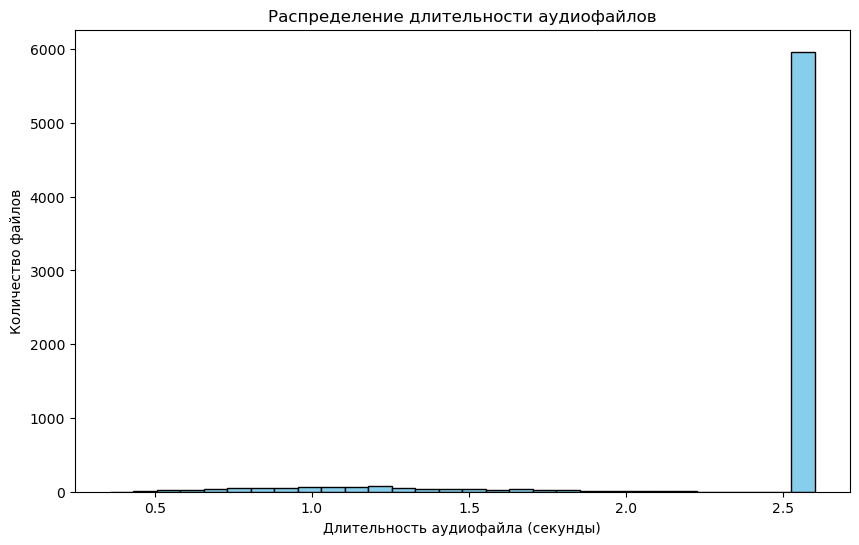

In [24]:
def get_audio_duration(filepath):
    """Возвращает длительность аудиофайла в секундах."""
    try:
        audio = AudioSegment.from_file(filepath)  # pydub автоматически определяет формат
        return len(audio) / 1000  # Длительность в секундах
    except Exception as e:
        print(f"Не удалось прочитать файл {filepath}: {e}")
        return None

# Корневая директория
root_dir = "output/ML"  # Укажите свою директорию

audio_durations = []

# Рекурсивный обход папок
for root, dirs, files in os.walk(root_dir):
    for file in files:
        if file.lower().endswith((".wav", ".opus", ".ogg", ".mp3", ".flac")):  # Добавляем больше форматов
            file_path = os.path.join(root, file)
            duration = get_audio_duration(file_path)
            if duration is not None:
                audio_durations.append(duration)

# Визуализация
plt.figure(figsize=(10, 6))
plt.hist(audio_durations, bins=30, color='skyblue', edgecolor='black')
plt.xlabel("Длительность аудиофайла (секунды)")
plt.ylabel("Количество файлов")
plt.title("Распределение длительности аудиофайлов")
plt.show()


In [27]:
# import zipfile

# def zip_folder(folder_path, output_zip):
#     try:
#         # Открываем zip-файл для записи
#         with zipfile.ZipFile(output_zip, 'w', zipfile.ZIP_DEFLATED) as zipf:
#             # Проходим по всем файлам и папкам в указанной директории
#             for root, dirs, files in os.walk(folder_path):
#                 for file in files:
#                     # Создаем путь к файлу в архиве
#                     file_path = os.path.join(root, file)
#                     arcname = os.path.relpath(file_path, folder_path)  # относительный путь
#                     # Добавляем файл в архив
#                     zipf.write(file_path, arcname)
#         print(f"Папка успешно запакована в {output_zip}")
#     except Exception as e:
#         print(f"Ошибка при упаковке: {e}")

# # Пример использования
# folder_path = "/kaggle/working/ML"  # Укажите путь к вашей папке
# output_zip = "/kaggle/working/ML.zip"  # Укажите путь для сохранения zip-файла

# zip_folder(folder_path, output_zip)